### Config

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from chronos_mlx import ChronosPipeline
pd.set_option('display.max_columns', None)

In [2]:
quart = pd.read_parquet('/Users/tomaltenborg/Documents/Master/Master thesis/Notebooks/M-Competitions/M3-Competition/Quarter/M3_quarter_processed.parquet')
quart_train = quart.loc[quart['Series'] == 646]
# quart = quart.loc[(quart['Series'] == 646) | (quart['Series'] == 647) | (quart['Series'] == 648)]

In [4]:
quart_train.head()

,Series,N,NF,Category,Measurement,Value,Date
0,646,44,8,MICRO,1,3142.63,1984-01-01
1,646,44,8,MICRO,2,3190.75,1984-04-01
2,646,44,8,MICRO,3,3178.69,1984-07-01
3,646,44,8,MICRO,4,3170.94,1984-10-01
4,646,44,8,MICRO,5,3124.38,1985-01-01


### Test

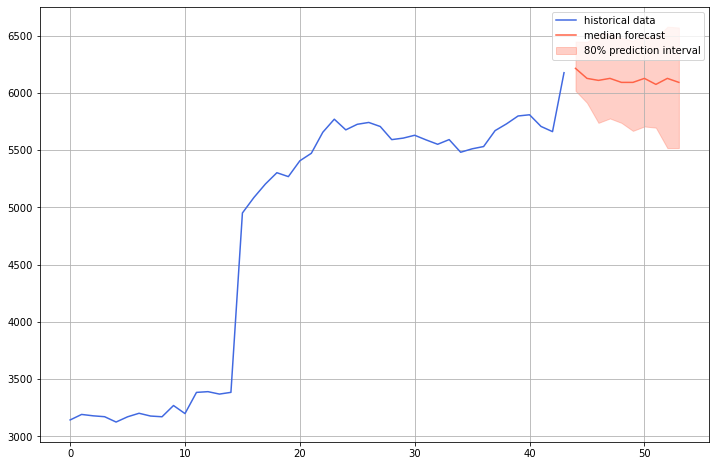

In [3]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    dtype="bfloat16",
)

context = quart_train["Value"].values
prediction_length = 10
forecast = pipeline.predict(
    context,
    prediction_length,
    num_samples=30,
    temperature=1.0,
    top_k=50,
    top_p=1.0
) # forecast shape: [num_series, num_samples, prediction_length]

# visualize the forecast
forecast_index = range(len(quart_train), len(quart_train) + prediction_length)
low, median, high = np.quantile(forecast[0], [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(12, 8))
plt.plot(quart_train["Value"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

## Loop and Produce Forecasts for All Quarterly Series

In [4]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    dtype="bfloat16",
)

unique_series = quart['Series'].unique()

forecasts = {}

for series_id in unique_series:
    # Filter the dataframe for the current series
    series_data = quart[quart['Series'] == series_id]
    
    # Ensure the data is sorted by date
    series_data = series_data.sort_values('Date')
    
    # Get the number of observations to use for forecasting
    N = series_data['N'].iloc[0]
    NF = series_data['NF'].iloc[0]
    
    # Get the date of the last observation used for training
    last_training_date = series_data['Date'].iloc[N-NF-1]  # -1 because iloc is 0-based

    # Prepare the input data for the model
    training_data = series_data['Value'].iloc[:N-NF].values  # Exclude the last NF values
    
    # Calculate forecast dates assuming quarterly data
    forecast_dates = pd.date_range(start=last_training_date, periods=NF+1, freq='Q')[1:]  # Skip the first since it's the last training date
    
    # Predict the next NF values
    try:
        model_forecasts = pipeline.predict(
            context=training_data,
            prediction_length=NF,
            num_samples=N-NF,
            temperature=1.0,
            top_k=50,
            top_p=1.0
        )#.squeeze(0).squeeze(0).numpy()  # Remove batch and sample dimensions for simplicity
    except Exception as e:
        print(f"Failed to predict for series {series_id} with error: {e}")
        continue
    
    # Quantiles for uncertainty bounds
    low, median, high = np.quantile(model_forecasts[0], [0.1, 0.5, 0.9], axis=0)
    forecasts[series_id] = {
        'Date': forecast_dates,
        'low': low,
        'median': median,
        'high': high
    }

# Convert forecasts dictionary to a DataFrame for easier manipulation
forecast_df = pd.DataFrame()
for series_id, data in forecasts.items():
    df_temp = pd.DataFrame({
        'Date': data['Date'],
        'Series_ID': series_id,
        'Low': data['low'],
        'Median': data['median'],
        'High': data['high']
    })
    forecast_df = pd.concat([forecast_df, df_temp], ignore_index=True)

# forecast_df.set_index(['Date', 'Series_ID'], inplace=True)
print('Forecasting completed for all series.')

<ipython-input-4-807aafd13546>:31: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  forecast_dates = pd.date_range(start=last_training_date, periods=NF+1, freq='Q')[1:]  # Skip the first since it's the last training date


Forecasting completed for all series.


In [8]:
forecast_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6048 entries, 0 to 6047
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6048 non-null   datetime64[ns]
 1   Series_ID  6048 non-null   int64         
 2   Low        6048 non-null   float64       
 3   Median     6048 non-null   float64       
 4   High       6048 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 236.4 KB


Slight issue. The datetime values here are a bit different from that in the processed parquet file, still the same quarter, but at the end of the month instead of the start. Should hardly matter. 

Need to decide how to use the low, median and high. Natural to just use median. For now save all of it.

In [10]:
forecast_df.to_parquet('M3_Chronos_quarter_forecast.parquet', index=False,  compression='gzip', engine='pyarrow')